In [2]:
from icrl import *

d:\Anaconda3\envs\textgen\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


bin d:\Anaconda3\envs\textgen\lib\site-packages\bitsandbytes\libbitsandbytes_cuda118.dll


## Setup 1

In [3]:
num_actions = 10
conext_dim = 5
env = Environment(num_actions, conext_dim)

# LinUCB
linucb = LinUCB(num_actions, conext_dim)

T = 200
num_trajectories = 100000

100,000 trajactories, 200 time steps each

In [4]:
import tqdm
trajectories = [] # Store all trajectories
# In this setting, s_t = \mathbb{A} = action_set!
all_regrets = np.zeros((num_trajectories, T))

# use tqdm to show progress bar

for i in tqdm.tqdm(range(num_trajectories)):

    total_regret = 0
    regrets = []
    best_action_index = env.get_best_action_index()  # Best action doesn't change in this setup
    best_action_reward = np.dot(env.action_set[best_action_index], env.w_star)
    states, actions, rewards, action_indexs = [], [], [], []
    
    for _ in range(T):
        action_index = linucb.select_action(env.action_set)
        reward, action = env.step(action_index)
        # find action
        linucb.update(reward, action)
        # Calculate regret for this round and add to total
        expected_reward = np.dot(env.action_set[action_index], env.w_star)
        
        round_regret = best_action_reward - expected_reward
        total_regret += round_regret
        # print(round_regret)
        # Store state, action, reward for this round
        states.append(env.get_action_set()) 
        actions.append(action)
        rewards.append(reward)
        action_indexs.append(action_index)
        regrets.append(total_regret)

    all_regrets[i] = regrets # Store regrets for this trajectory
    trajectories.append((states, actions, rewards, action_indexs)) # Store trajectory
    # Reset env and LinUCB for next trajectory
    env.reset()
    linucb.reset()

100%|██████████| 100000/100000 [56:53<00:00, 29.30it/s] 


In [5]:
# Use dataframes to store the data
import pandas as pd
df_regrets= pd.DataFrame(all_regrets)
df_regrets.to_csv('data/linucb_regrets.csv', index=False)



In [6]:
import pickle

# 假设 trajectories 是一个大型列表，可以被分为多个较小的部分
chunk_size = 20000  # 根据实际情况设定合适的大小
for i in range(0, len(trajectories), chunk_size):
    with open(f'data/linucb_trajectories_part{i//chunk_size}.pkl', 'wb') as f:
        pickle.dump(trajectories[i:i+chunk_size], f)


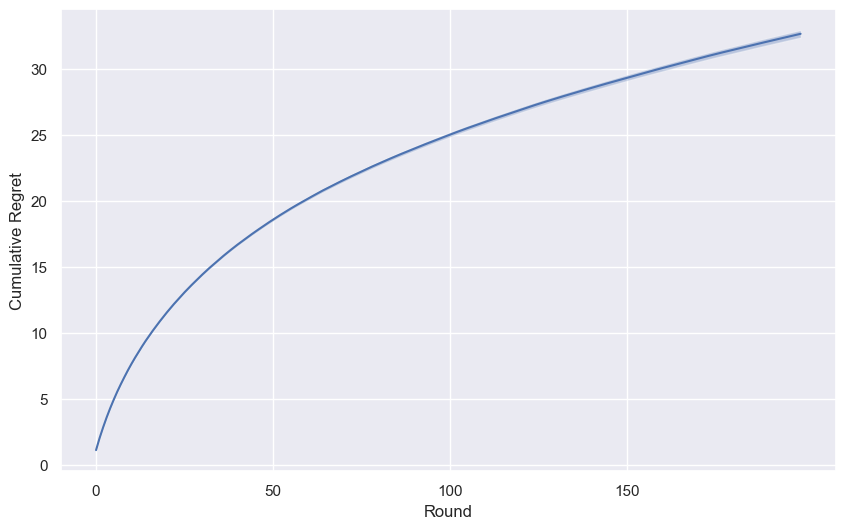

In [ ]:
# Plot the average regret with confidence interval
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# load data
df_regrets = pd.read_csv('data/linucb_regrets.csv')

sns.set()
plt.figure(figsize=(10, 6))
plt.plot(df_regrets.mean(), label='LinUCB')
plt.fill_between(df_regrets.columns, df_regrets.mean() - df_regrets.std()/np.sqrt(num_trajectories), df_regrets.mean() + df_regrets.std()/np.sqrt(num_trajectories), alpha=0.3)
plt.xlabel('Round')
# ever 50 rounds set a x-tick
plt.xticks(np.arange(0, T, 50))
plt.ylabel('Cumulative Regret')
plt.savefig('linucb_regret.png')
plt.show()


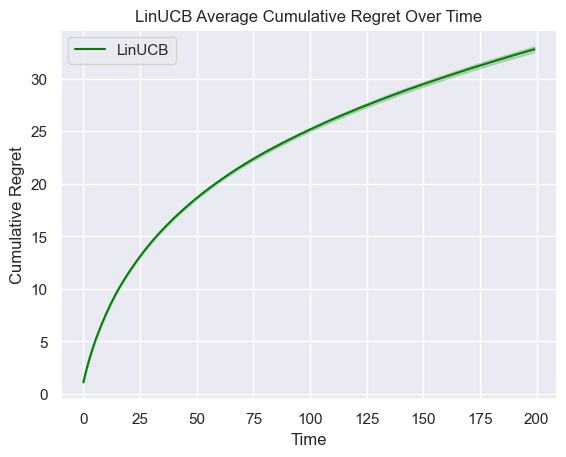

In [11]:
# 计算每一步的平均累计遗憾和标准差
average_regrets = df_regrets.mean(axis=0)
std_regrets = df_regrets.std(axis=0)/np.sqrt(num_trajectories)

# 时间点
time_steps = np.arange(200)

# 绘制平均累计遗憾
plt.plot(time_steps, average_regrets, label='LinUCB', color='green')

# 绘制标准差阴影区域
plt.fill_between(time_steps, average_regrets - std_regrets, average_regrets + std_regrets, color='green', alpha=0.2)

# 设置图表标签和标题
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('LinUCB Average Cumulative Regret Over Time')
plt.legend()
plt.show()

# Thompson Sampling

In [19]:
num_actions = 10
conext_dim = 5

env = Environment(num_actions, conext_dim)
# Thompson Sampling
thompson = ThompsonSampling(num_actions, conext_dim)

In [20]:
import tqdm
T = 200
num_trajectories = 10000

trajectories = [] # Store all trajectories
# In this setting, s_t = \mathbb{A} = action_set!
all_regrets = np.zeros((num_trajectories, T))

# use tqdm to show progress bar

for i in tqdm.tqdm(range(num_trajectories)):

    total_regret = 0
    regrets = []
    best_action_index = env.get_best_action_index()  # Best action doesn't change in this setup
    best_action_reward = np.dot(env.action_set[best_action_index], env.w_star)
    states, actions, rewards, action_indexs = [], [], [], []

    for _ in range(T):
        action_index = thompson.select_action(env.action_set)
        reward, action = env.step(action_index)
        # find action
        thompson.update(reward, action)
        # Calculate regret for this round and add to total
        expected_reward = np.dot(env.action_set[action_index], env.w_star)
        
        round_regret = best_action_reward - expected_reward
        # print(round_regret)
        total_regret += round_regret

        # Store state, action, reward for this round
        states.append(env.get_action_set()) 
        actions.append(action)
        rewards.append(reward)
        action_indexs.append(action_index)
        regrets.append(total_regret)

    all_regrets[i] = regrets # Store regrets for this trajectory
    trajectories.append((states, actions, rewards, action_indexs)) # Store trajectory
    # Reset env and LinUCB for next trajectory
    env.reset()
    thompson.reset()

 15%|█▌        | 1501/10000 [01:02<05:55, 23.88it/s]


KeyboardInterrupt: 

In [ ]:
# Use dataframes to store the data
import pandas as pd
df_regrets= pd.DataFrame(all_regrets)
df_regrets.to_csv('Thompson_regrets.csv', index=False)


# Save trajectories
import pickle
with open('Thompson_trajectories.pkl', 'wb') as f:
    pickle.dump(trajectories, f)

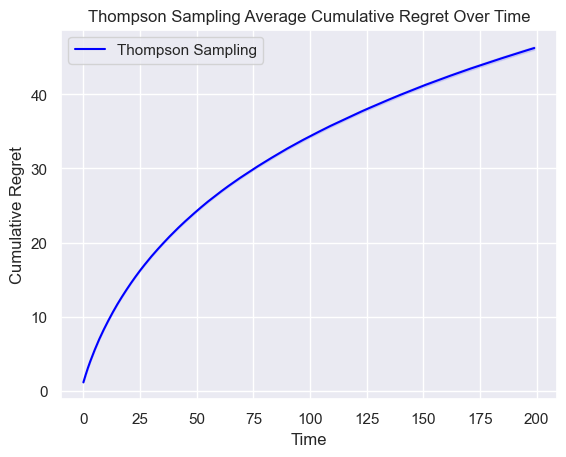

In [23]:
# 计算每一步的平均累计遗憾和标准差
df_regrets = pd.read_csv('Thompson_regrets.csv')

average_regrets = df_regrets.mean(axis=0)
std_regrets = df_regrets.std(axis=0)/np.sqrt(num_trajectories)

# 时间点
time_steps = np.arange(200)

# 绘制平均累计遗憾
plt.plot(time_steps, average_regrets, label='Thompson Sampling', color='blue')

# 绘制标准差阴影区域
plt.fill_between(time_steps, average_regrets - std_regrets, average_regrets + std_regrets, color='blue', alpha=0.1)

# 设置图表标签和标题
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('Thompson Sampling Average Cumulative Regret Over Time')
plt.legend()
plt.show()

In [1]:
# random trajectory
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from icrl import *

num_actions = 10
conext_dim = 5

env = Environment(num_actions, conext_dim)
randomchoose = RandomChoose(num_actions, conext_dim)
import tqdm
T = 200
num_trajectories = 100000

trajectories = [] # Store all trajectories
# In this setting, s_t = \mathbb{A} = action_set!
all_regrets = np.zeros((num_trajectories, T))

# use tqdm to show progress bar

for i in tqdm.tqdm(range(num_trajectories)):

    total_regret = 0
    regrets = []
    best_action_index = env.get_best_action_index()  # Best action doesn't change in this setup
    best_action_reward = np.dot(env.action_set[best_action_index], env.w_star)
    states, actions, rewards, action_indexs = [], [], [], []

    for _ in range(T):
        action_index = randomchoose.select_action(env.action_set)
        reward, action = env.step(action_index)
        # # find action
        # thompson.update(reward, action)
        # Calculate regret for this round and add to total
        expected_reward = np.dot(env.action_set[action_index], env.w_star)
        
        round_regret = best_action_reward - expected_reward
        # print(round_regret)
        total_regret += round_regret

        # Store state, action, reward for this round
        states.append(env.get_action_set()) 
        actions.append(action)
        rewards.append(reward)
        action_indexs.append(action_index)
        regrets.append(total_regret)

    all_regrets[i] = regrets # Store regrets for this trajectory
    trajectories.append((states, actions, rewards, action_indexs)) # Store trajectory
    # Reset env and LinUCB for next trajectory
    env.reset()
    # thompson.reset()

d:\Anaconda3\envs\textgen\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


bin d:\Anaconda3\envs\textgen\lib\site-packages\bitsandbytes\libbitsandbytes_cuda118.dll


100%|██████████| 100000/100000 [05:22<00:00, 310.28it/s]


In [2]:
# Use dataframes to store the data
import pandas as pd
df_regrets= pd.DataFrame(all_regrets)
df_regrets.to_csv('data/RandomChoose_regrets.csv', index=False)

In [3]:
# Save trajectories
import pickle
chunk_size = 20000
for i in range(0, len(trajectories), chunk_size):
    with open(f'data/RandomChoose_trajectories_part{i//chunk_size}.pkl', 'wb') as f:
        pickle.dump(trajectories[i:i+chunk_size], f)

# Pretrain Transformers

In [3]:
from icrl import *
from model import *

num_actions = 10
context_dim = 5
env = Environment(num_actions, context_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load model
model = TransformerModel(embed_dim=70, num_heads=5)

In [4]:
batchsize = 64

In [6]:
# load model from file
from model import Transformer
import tqdm 
config = {
        'horizon': 200,
        'dim':5,
        'act_num':10,
        'state_dim': 50,
        'action_dim': 10,
        'n_layer': 8,
        'n_embd': 32,
        'n_head': 4,
        'shuffle': True,
        'dropout': 0,
        'test': True,
        'activation': 'relu',
        'pred_q': False,
    }
num_actions = 10
context_dim = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
T = 400


model = Transformer(config)
model.load_state_dict(torch.load('model/transformer_model.pth'))
model.to(device)
model.eval()  # 确保模型在评估模式
# evaluate the model
num_trajectories = 1000

batchsize = 8

trajectories = [] # Store all trajectories
# In this setting, s_t = \mathbb{A} = action_set!
all_regrets = np.zeros((num_trajectories, T))

# use tqdm to show progress bar
# for i in tqdm.tqdm(range(num_trajectories)):
for i in tqdm.tqdm(range(num_trajectories//batchsize)):

    envs = [Environment(num_actions, context_dim) for _ in range(batchsize)]
    total_regret = np.zeros(batchsize)
    # regrets = np.zeros((batchsize, T))
    regrets = [[] for _ in range(batchsize)]

    best_action_indexs = [env.get_best_action_index() for env in envs]  # Best action doesn't change in this setup
    best_action_rewards = [np.dot(env.action_set[best_action_index], env.w_star) for env, best_action_index in zip(envs, best_action_indexs)]
    states, actions, rewards, action_indexs = [[] for _ in range(batchsize)], [[] for _ in range(batchsize)], [[] for _ in range(batchsize)], [[] for _ in range(batchsize)]
    action_sets = [torch.tensor(env.get_action_set(), dtype=torch.float32).to(device).reshape(-1) for env in envs]
    # action_sets shape: [batchsize, num_actions*context_dim]
    action_sets = torch.stack(action_sets).reshape(batchsize, -1) # [batchsize, num_actions*context_dim]
    # print(action_sets.shape)
    # embeddings = [[] for _ in range(batchsize)]
    # embeddings = torch.zeros((batchsize, T, 70), dtype=torch.float32).to(device)
    # # regrets = []
    # best_action_index = env.get_best_action_index()  # Best action doesn't change in this setup
    # best_action_reward = np.dot(env.action_set[best_action_index], env.w_star)
    # states, actions, rewards, action_indexs = [], [], [], []

    # embeddings = []
    for t in range(1, T+1):
        if t == 1:
            context_actions = torch.empty((batchsize, 0, num_actions), dtype=torch.float32).to(device)
            context_rewards = torch.empty((batchsize, 0, 1), dtype=torch.float32).to(device)
            x = {
                'action_set': action_sets,
                'context_actions': context_actions,
                'context_rewards': context_rewards
            }
        else:
            x = {
                'action_set': action_sets,
                'context_actions': context_actions,
                'context_rewards': context_rewards
            }
        last_timestep_outputs = model(x) 
        # last_timestep_outputs shape: [batchsize, num_actions]
        action_indices = torch.multinomial(F.softmax(last_timestep_outputs, dim=-1), 1) #dimension [batchsize, 1]

        # choose 2t-1 the last one
        # print(action_indices.shape)
        # action_indices = action_index[:][-1].argmax().item()
        # print(action_index)
        # [2*t-1].argmax().item()

        rewards_ = [env.step(action_index)[0] for env, action_index in zip(envs, action_indices)]
        actions_ = [env.step(action_index)[1] for env, action_index in zip(envs, action_indices)]
        # print(len(actions_))
        # find action
        actions_one_hot = torch.zeros(batchsize, 1, num_actions).to(device)
        actions_one_hot.scatter_(2, action_indices.unsqueeze(1), 1)

        reward_tensor = torch.tensor(rewards_, dtype=torch.float32).to(device).reshape(batchsize, 1, 1)
        
        context_actions = torch.cat([context_actions, actions_one_hot], dim=1)
        context_rewards = torch.cat([context_rewards, reward_tensor], dim=1)

        
        expected_rewards = [np.dot(env.action_set[action_index], env.w_star) for env, action_index in zip(envs, action_indices)]
        
        # round_regret = best_action_reward - expected_reward
        round_regrets = [best_action_reward - expected_reward for best_action_reward, expected_reward in zip(best_action_rewards, expected_rewards)]
        # print(round_regret)
        # total_regret += round_regret
        total_regret += round_regrets

        # Store state, action, reward for this round
        # states.append(env.get_action_set()) 
        # actions.append(action)
        # rewards.append(reward)
        # action_indexs.append(action_index)
        # regrets.append(total_regret)
        for j in range(batchsize):
            regrets[j].append(total_regret[j])
            states[j].append(envs[j].get_action_set())
            actions[j].append(actions_[j])
            rewards[j].append(rewards_[j])
            action_indexs[j].append(action_indices[j].item())

    # all_regrets[i] = regrets # Store regrets for this trajectory
    all_regrets[i*batchsize:(i+1)*batchsize] = regrets
    trajectories.append((states, actions, rewards, action_indexs)) # Store trajectory
    # Reset env and LinUCB for next trajectory
    # for env in envs:
    #     env.reset()


100%|██████████| 31/31 [05:54<00:00, 11.44s/it]


In [7]:
import pandas as pd
df_regrets = pd.DataFrame(all_regrets)
df_regrets.to_csv('data/transformer_400steps_regrets.csv', index=False)

In [10]:
# save the regrets
import pandas as pd
df_regrets = pd.DataFrame(all_regrets)
df_regrets.to_csv('data/transformer_regrets.csv', index=False)

(1000, 400)


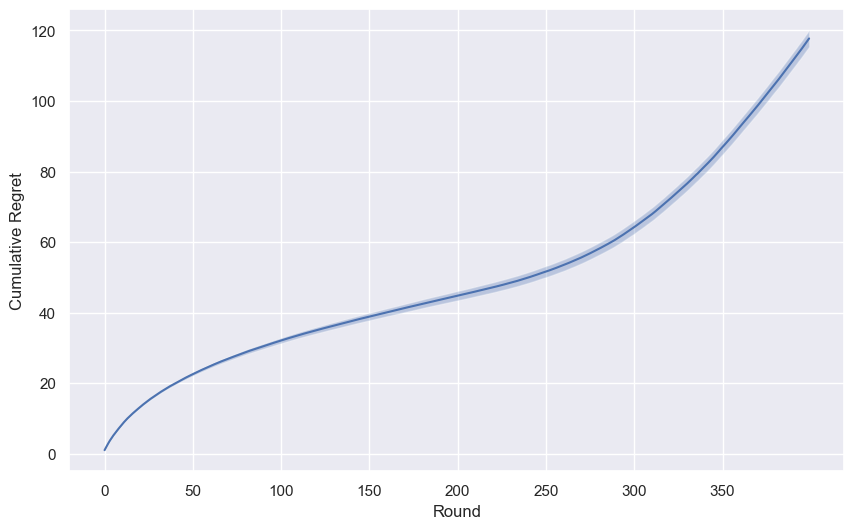

In [8]:

# plot the average regret with confidence interval
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# load data
# df_regrets = pd.read_csv('data/transformer_regrets.csv')
df_regrets = pd.read_csv('data/transformer_400steps_regrets.csv')
print(df_regrets.shape)
sns.set()
plt.figure(figsize=(10, 6))
plt.plot(df_regrets.mean(), label='Transformer')
plt.fill_between(df_regrets.columns, df_regrets.mean() - df_regrets.std()/np.sqrt(num_trajectories), df_regrets.mean() + df_regrets.std()/np.sqrt(num_trajectories), alpha=0.3)
plt.xlabel('Round')
# ever 50 rounds set a x-tick
plt.xticks(np.arange(0, T, 50))
plt.ylabel('Cumulative Regret')
plt.savefig('transformer_regret.png')

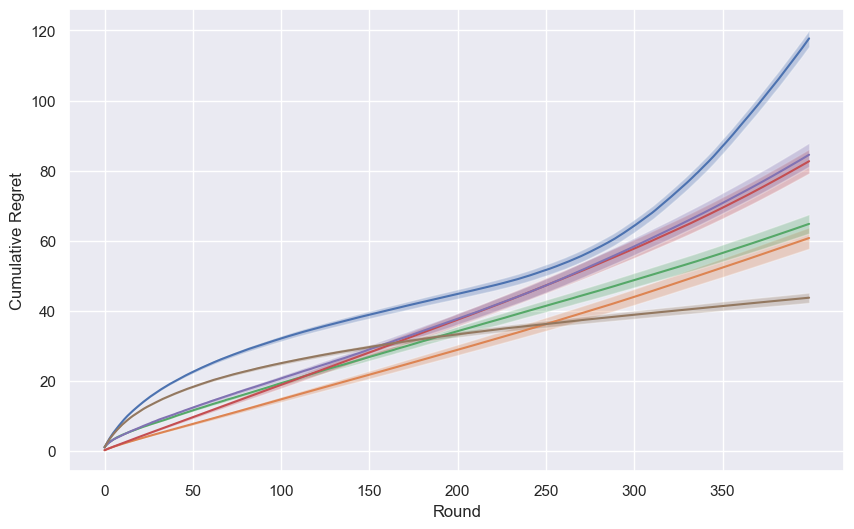

In [9]:
# 400steps
df_regrets = pd.read_csv('data/transformer_400steps_regrets.csv')
df_regrets_1 = pd.read_csv('data/Qtransformer random softmax greedy 400steps_regrets.csv')
df_regrets_2 = pd.read_csv('data/Qtransformer random softmax 1_t 400steps_regrets.csv')
df_regrets_3 = pd.read_csv('data/Qtransformer linucb softmax greedy 400steps_regrets.csv')
df_regrets_4 = pd.read_csv('data/Qtransformer linucb softmax 1_t 400steps_regrets.csv')
df_linucb = pd.read_csv('data/linucb_400steps_regrets.csv')

sns.set()
plt.figure(figsize=(10, 6))
plt.plot(df_regrets.mean(), label='Imitation Learning')
plt.plot(df_regrets_1.mean(), label='Qlearning Random softmax greedy')
plt.plot(df_regrets_2.mean(), label='Qlearning Random softmax epsilon = 1_t')
plt.plot(df_regrets_3.mean(), label='Qlearning LinUCB softmax greedy')
plt.plot(df_regrets_4.mean(), label='Qlearning LinUCB softmax epsilon = 1_t')
plt.plot(df_linucb.mean(), label='LinUCB')

plt.fill_between(df_regrets.columns, df_regrets.mean() - df_regrets.std()/np.sqrt(len(df_regrets)), df_regrets.mean() + df_regrets.std()/np.sqrt(len(df_regrets)), alpha=0.3)
plt.fill_between(df_regrets_1.columns, df_regrets_1.mean() - df_regrets_1.std()/np.sqrt(len(df_regrets_1)), df_regrets_1.mean() + df_regrets_1.std()/np.sqrt(len(df_regrets_1)), alpha=0.3)
plt.fill_between(df_regrets_2.columns, df_regrets_2.mean() - df_regrets_2.std()/np.sqrt(len(df_regrets_2)), df_regrets_2.mean() + df_regrets_2.std()/np.sqrt(len(df_regrets_2)), alpha=0.3)
plt.fill_between(df_regrets_3.columns, df_regrets_3.mean() - df_regrets_3.std()/np.sqrt(len(df_regrets_3)), df_regrets_3.mean() + df_regrets_3.std()/np.sqrt(len(df_regrets_3)), alpha=0.3)
plt.fill_between(df_regrets_4.columns, df_regrets_4.mean() - df_regrets_4.std()/np.sqrt(len(df_regrets_4)), df_regrets_4.mean() + df_regrets_4.std()/np.sqrt(len(df_regrets_4)), alpha=0.3)
plt.fill_between(df_linucb.columns, df_linucb.mean() - df_linucb.std()/np.sqrt(len(df_linucb)), df_linucb.mean() + df_linucb.std()/np.sqrt(len(df_linucb)), alpha=0.3)
plt.xlabel('Round')
# ever 50 rounds set a x-tick
plt.xticks(np.arange(0, T, 50))
plt.ylabel('Cumulative Regret')
plt.savefig('all_regret_400steps.png')
plt.show()


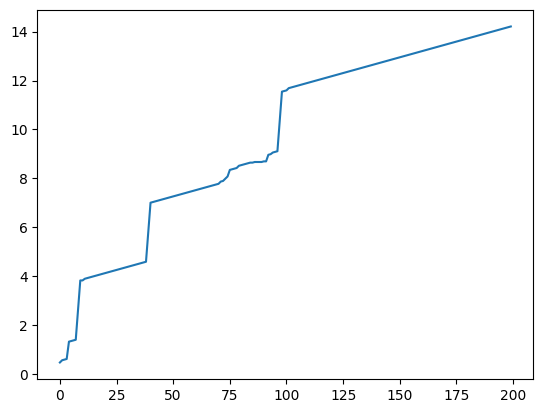

In [23]:
# eval the transformer model
from icrl import *
from model import *
config = {
        'horizon': 200,
        'dim':5,
        'act_num':10,
        'state_dim': 50,
        'action_dim': 10,
        'n_layer': 8,
        'n_embd': 32,
        'n_head': 4,
        'shuffle': True,
        'dropout': 0,
        'test': True,
        'act_type': 'relu',
    }
num_actions = 10
context_dim = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
T = 200


model = Transformer(config)
model.load_state_dict(torch.load('model/transformer_model.pth'))
model.to(device)
model.eval()  # 确保模型在评估模式

env = Environment(num_actions, context_dim)
best_action_index = env.get_best_action_index()  # Best action doesn't change in this setup
best_action_reward = np.dot(env.action_set[best_action_index], env.w_star)
# evaluate the model
total_regrets = np.zeros(T)
total_regret = 0
action_set = env.get_action_set()
action_set = torch.tensor(action_set, dtype=torch.float32).to(device).reshape(-1)
action_indices = []
rewards = []

for t in range(1, T+1):
    if t == 1:
        context_actions = torch.empty(0, num_actions).to(device).unsqueeze(0) # batch_size, 0, num_actions
        context_rewards = torch.empty(0, 1).to(device).unsqueeze(0) # batch_size, 0, 1
        x = {
            'action_set': action_set.unsqueeze(0),
            'context_actions': context_actions,
            'context_rewards': context_rewards
        }
    else:
        x = {
            'action_set': action_set.unsqueeze(0),
            'context_actions': context_actions,
            'context_rewards': context_rewards
        }
        # action_indices = model(x)

    last_timestep_outputs = model(x)
    # last_timestep_outputs = model_outputs[:, -1, :]

    # 找到最后一个时间步中每个动作得分最高的索引
    # action_indices = last_timestep_outputs.argmax(dim=1)
    # 找到最后一个时间步，用softmax算出每个动作的概率，并按照概率随机选择动作
    action_indices = torch.multinomial(torch.softmax(last_timestep_outputs, dim=1), 1)

    rewards_ = env.step(action_indices[0].item())[0]
    actions_ = env.step(action_indices[0].item())[1]
    # 转化成一个one-hot向量
    actions_one_hot = torch.zeros(1, 1, num_actions).to(device) # batch_size, 1, num_actions

    actions_one_hot.scatter_(2, action_indices.unsqueeze(0), 1) # batch_size, num_actions

    reward_tensor = torch.tensor(rewards_, dtype=torch.float32).to(device).unsqueeze(0).unsqueeze(0).unsqueeze(0) # batch_size, 1, 1
    # print(reward_tensor.shape)
    context_actions = torch.cat((context_actions, actions_one_hot), dim=1)
    context_rewards = torch.cat((context_rewards, reward_tensor), dim=1)

    # Calculate regret for this round and add to total
    expected_reward = np.dot(env.action_set[action_indices[0].item()], env.w_star)
    # print(expected_reward)
    round_regret = best_action_reward - expected_reward
    total_regret += round_regret
    total_regrets[t-1] = total_regret
# 画出total regret，横轴是时间，纵轴是累计遗憾
plt.plot(total_regrets)

# Pretrain QTransformer

In [1]:
# load model from file
import tqdm 
from model import *
from icrl import *
config = {
        'horizon': 200,
        'dim':5,
        'act_num':10,
        'state_dim': 50,
        'action_dim': 10,
        'n_layer': 8,
        'n_embd': 32,
        'n_head': 4,
        'shuffle': True,
        'dropout': 0,
        'test': True,
        'act_type': 'relu',
        'pred_q': True,
    }
num_actions = 10
context_dim = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
T = 200


model = Transformer(config)
# model.load_state_dict(torch.load('model/Qtransformer_model_0706_2.pth'))
# model.load_state_dict(torch.load('model/Qtransformer_model_random_0717_gamma_1.pth'))
model.load_state_dict(torch.load('model/Qtransformer_model_ucb_0718_gamma_1.pth'))
# model.load_state_dict(torch.load('model/Qtransformer_model_new_1.pth'))
model.to(device)
model.eval()  # 确保模型在评估模式
# evaluate the model
num_trajectories = 1000

batchsize = 32

trajectories = [] # Store all trajectories
# In this setting, s_t = \mathbb{A} = action_set!
all_regrets = np.zeros((num_trajectories, T))
initilize_prob = 1

for i in tqdm.tqdm(range(num_trajectories//batchsize)):

    envs = [Environment(num_actions, context_dim) for _ in range(batchsize)]
    total_regret = np.zeros(batchsize)
    # regrets = np.zeros((batchsize, T))
    regrets = [[] for _ in range(batchsize)]

    best_action_indexs = [env.get_best_action_index() for env in envs]  # Best action doesn't change in this setup
    best_action_rewards = [np.dot(env.action_set[best_action_index], env.w_star) for env, best_action_index in zip(envs, best_action_indexs)]
    states, actions, rewards, action_indexs = [[] for _ in range(batchsize)], [[] for _ in range(batchsize)], [[] for _ in range(batchsize)], [[] for _ in range(batchsize)]
    action_sets = [torch.tensor(env.get_action_set(), dtype=torch.float32).to(device).reshape(-1) for env in envs]
    # action_sets shape: [batchsize, num_actions*context_dim]
    action_sets = torch.stack(action_sets).reshape(batchsize, -1) # [batchsize, num_actions*context_dim]
   

    initial_tao = 0.01
    for t in range(1, T+1):
        if t == 1:
            context_actions = torch.empty((batchsize, 0, num_actions), dtype=torch.float32).to(device)
            context_rewards = torch.empty((batchsize, 0, 1), dtype=torch.float32).to(device)
            x = {
                'action_set': action_sets,
                'context_actions': context_actions,
                'context_rewards': context_rewards
            }
        else:
            x = {
                'action_set': action_sets,
                'context_actions': context_actions,
                'context_rewards': context_rewards
            }
        random_number = np.random.rand()
        if random_number < initilize_prob/np.sqrt(t):
        # if t <= 30:
            action_indices = torch.randint(0, num_actions, (batchsize, 1)).to(device)
            # choose t%num_actions
            # action_indices = torch.tensor([t%num_actions]*batchsize).to(device).unsqueeze(1)
        else:
            last_timestep_outputs = model(x) 
            # last_timestep_outputs shape: [batchsize, num_actions]
            # action_indices = torch.multinomial(F.softmax(last_timestep_outputs, dim=-1), 1)
            action_indices = last_timestep_outputs.argmax(dim=-1).unsqueeze(1)
            # 接一个softmax
            # tao = initial_tao/np.sqrt(t)
            # action_indices = torch.multinomial(F.softmax(last_timestep_outputs/tao, dim=-1), 1) #dimension [batchsize, 1]
            
        # last_timestep_outputs = model(x) 
        # [2*t-1].argmax().item()

        rewards_ = [env.step(action_index)[0] for env, action_index in zip(envs, action_indices)]
        actions_ = [env.step(action_index)[1] for env, action_index in zip(envs, action_indices)]
        # print(len(actions_))
        # find action
        actions_one_hot = torch.zeros(batchsize, 1, num_actions).to(device)
        actions_one_hot.scatter_(2, action_indices.unsqueeze(1), 1)

        reward_tensor = torch.tensor(rewards_, dtype=torch.float32).to(device).reshape(batchsize, 1, 1)
        
        context_actions = torch.cat([context_actions, actions_one_hot], dim=1)
        context_rewards = torch.cat([context_rewards, reward_tensor], dim=1)
        # print(context_rewards.shape)
        # print(context_actions.shape)
        
        expected_rewards = [np.dot(env.action_set[action_index], env.w_star) for env, action_index in zip(envs, action_indices)]
        
        # round_regret = best_action_reward - expected_reward
        round_regrets = [best_action_reward - expected_reward for best_action_reward, expected_reward in zip(best_action_rewards, expected_rewards)]
        # print(round_regret)
        # total_regret += round_regret
        total_regret += round_regrets
        for j in range(batchsize):
            regrets[j].append(total_regret[j])
            states[j].append(envs[j].get_action_set())
            actions[j].append(actions_[j])
            rewards[j].append(rewards_[j])
            action_indexs[j].append(action_indices[j].item())

    # all_regrets[i] = regrets # Store regrets for this trajectory
    all_regrets[i*batchsize:(i+1)*batchsize] = regrets
    trajectories.append((states, actions, rewards, action_indexs)) # Store trajectory
    # Reset env and LinUCB for next trajectory
    # for env in envs:
    #     env.reset()


d:\Anaconda3\envs\textgen\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


bin d:\Anaconda3\envs\textgen\lib\site-packages\bitsandbytes\libbitsandbytes_cuda118.dll


FileNotFoundError: [Errno 2] No such file or directory: 'model/Qtransformer_model_ucb_0718_gamma_1.pth'

Text(0, 0.5, 'Cumulative Regret')

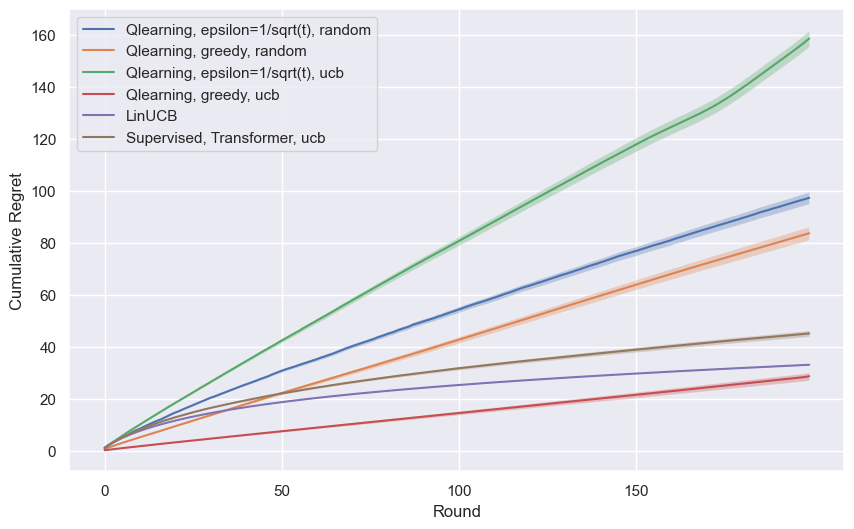

In [12]:
# save the regrets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_regrets = pd.DataFrame(all_regrets)
# df_regrets.to_csv('data/Qtransformer_random_regrets_0706_2_mix1.csv', index=False)
# df_regrets.to_csv('data/Qtransformer_random_regrets_new_2.csv', index=False)
# df_regrets.to_csv('data/Qtransformer_regrets_random_0717_gamma_1.csv', index=False)
df_regrets.to_csv('data/Qtransformer_regrets_ucb_0718_gamma_1.csv', index=False)



## gamma=0.5
# df_regrets_1 = pd.read_csv('data/Qtransformer_regrets_random_0715.csv')
# df_regrets_2 = pd.read_csv('data/Qtransformer_regrets_random_0715_greedy.csv')
# df_regrets_3 = pd.read_csv('data/Qtransformer_regrets_ucb_0714.csv')
df_regrets_4 = pd.read_csv('data/Qtransformer_regrets_ucb_0714_greedy.csv')

## gamma=1

# df_regrets_1 = pd.read_csv('data/Qtransformer_regrets_random_0715.csv')
df_regrets_1 = pd.read_csv('data/Qtransformer_regrets_random_0718_gamma_1.csv')
# df_regrets_2 = pd.read_csv('data/Qtransformer_random_regrets_new_2.csv')
# df_regrets_2 = pd.read_csv('data/Qtransformer_regrets_random_0715_greedy.csv')
df_regrets_2 = pd.read_csv('data/Qtransformer_regrets_random_0717_greedy_gamma_1.csv')
df_regrets_3 = pd.read_csv('data/Qtransformer_regrets_ucb_0717_gamma_1.csv')
# df_regrets_4 = pd.read_csv('data/Qtransformer_regrets_ucb_0717_gamma_1_greedy.csv')

df_linucb = pd.read_csv('data/linucb_regrets.csv')
# df_thompson = pd.read_csv('data/Thompson_regrets.csv')
df_transformer = pd.read_csv('data/transformer_regrets.csv')
# df_transformer_random = pd.read_csv('data/transformer_random_regrets.csv')
# df_Qtransformer = pd.read_csv('data/Qtransformer_random_regrets.csv')
# df_Qtransformer_ucb = pd.read_csv('data/Qtransformer_ucb_regrets.csv')
T=200
sns.set()
plt.figure(figsize=(10, 6))
# 画一条(0,0)到(200, 90)的直线
# plt.plot([0, 200], [0, 93], color='black', linestyle='--', label='reference')
plt.plot(df_regrets_1.mean(), label='Qlearning, epsilon=1/sqrt(t), random')
plt.plot(df_regrets_2.mean(), label='Qlearning, greedy, random')
plt.plot(df_regrets_3.mean(), label='Qlearning, epsilon=1/sqrt(t), ucb')
plt.plot(df_regrets_4.mean(), label='Qlearning, greedy, ucb')
plt.plot(df_linucb.mean(), label='LinUCB')
# plt.plot(df_thompson.mean(), label='Thompson Sampling')
plt.plot(df_transformer.mean(), label='Supervised, Transformer, ucb')
# plt.plot(df_transformer_random.mean(), label='Supervised, Transformer, random')


plt.fill_between(df_regrets_1.columns, df_regrets_1.mean() - df_regrets_1.std()/np.sqrt(len(df_regrets_1)), df_regrets_1.mean() + df_regrets_1.std()/np.sqrt(len(df_regrets_1)), alpha=0.3)
plt.fill_between(df_regrets_2.columns, df_regrets_2.mean() - df_regrets_2.std()/np.sqrt(len(df_regrets_2)), df_regrets_2.mean() + df_regrets_2.std()/np.sqrt(len(df_regrets_2)), alpha=0.3)
plt.fill_between(df_regrets_3.columns, df_regrets_3.mean() - df_regrets_3.std()/np.sqrt(len(df_regrets_3)), df_regrets_3.mean() + df_regrets_3.std()/np.sqrt(len(df_regrets_3)), alpha=0.3)
plt.fill_between(df_regrets_4.columns, df_regrets_4.mean() - df_regrets_4.std()/np.sqrt(len(df_regrets_4)), df_regrets_4.mean() + df_regrets_4.std()/np.sqrt(len(df_regrets_4)), alpha=0.3)
plt.fill_between(df_linucb.columns, df_linucb.mean() - df_linucb.std()/np.sqrt(len(df_linucb)), df_linucb.mean() + df_linucb.std()/np.sqrt(len(df_linucb)), alpha=0.3)
# plt.fill_between(df_thompson.columns, df_thompson.mean() - df_thompson.std()/np.sqrt(num_trajectories), df_thompson.mean() + df_thompson.std()/np.sqrt(num_trajectories), alpha=0.3)
plt.fill_between(df_transformer.columns, df_transformer.mean() - df_transformer.std()/np.sqrt(len(df_transformer)), df_transformer.mean() + df_transformer.std()/np.sqrt(len(df_transformer)), alpha=0.3)
# plt.fill_between(df_transformer_random.columns, df_transformer_random.mean() - df_transformer_random.std()/np.sqrt(len(df_transformer_random)), df_transformer_random.mean() + df_transformer_random.std()/np.sqrt(len(df_transformer_random)), alpha=0.3)


plt.legend()
plt.xlabel('Round')
# ever 50 rounds set a x-tick
plt.xticks(np.arange(0, T, 50))
plt.ylabel('Cumulative Regret')


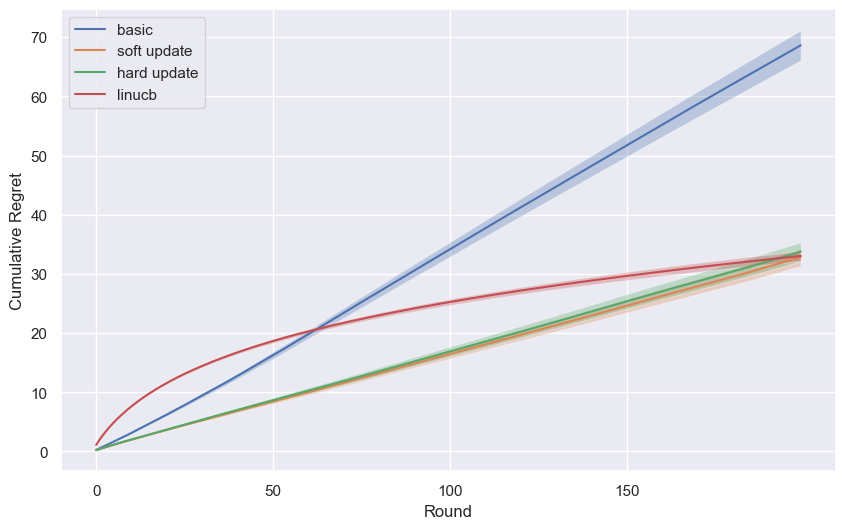

In [17]:

# plot the average regret with confidence interval
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# load data
df_regrets = pd.read_csv('data/Qtransformer_random_regrets.csv')
df_regrets_1 = pd.read_csv('data/Qtransformer_random_regrets_0706_1.csv')
df_regrets_2 = pd.read_csv('data/Qtransformer_random_regrets_0706_2.csv')

df_regrets_ucb = pd.read_csv('data/linucb_regrets.csv')
# df_regrets = pd.read_csv('data/Qtransformer_ucb_regrets.csv')
# print(df_regrets.shape)
sns.set()
plt.figure(figsize=(10, 6))
plt.plot(df_regrets.mean(), label='basic')
plt.fill_between(df_regrets.columns, df_regrets.mean() - df_regrets.std()/np.sqrt(num_trajectories), df_regrets.mean() + df_regrets.std()/np.sqrt(num_trajectories), alpha=0.3)
plt.plot(df_regrets_1.mean(), label='soft update')
plt.fill_between(df_regrets_1.columns, df_regrets_1.mean() - df_regrets_1.std()/np.sqrt(num_trajectories), df_regrets_1.mean() + df_regrets_1.std()/np.sqrt(num_trajectories), alpha=0.3)
plt.plot(df_regrets_2.mean(), label='hard update')
plt.fill_between(df_regrets_2.columns, df_regrets_2.mean() - df_regrets_2.std()/np.sqrt(num_trajectories), df_regrets_2.mean() + df_regrets_2.std()/np.sqrt(num_trajectories), alpha=0.3)
plt.plot(df_regrets_ucb.mean(), label='linucb')
plt.fill_between(df_regrets_ucb.columns, df_regrets_ucb.mean() - df_regrets_ucb.std()/np.sqrt(num_trajectories), df_regrets_ucb.mean() + df_regrets_ucb.std()/np.sqrt(num_trajectories), alpha=0.3)

# show the label
plt.legend()

plt.xlabel('Round')
# ever 50 rounds set a x-tick
plt.xticks(np.arange(0, T, 50))
plt.ylabel('Cumulative Regret')
plt.savefig('Qtransformer_regret.png')

Text(0, 0.5, 'Cumulative Regret')

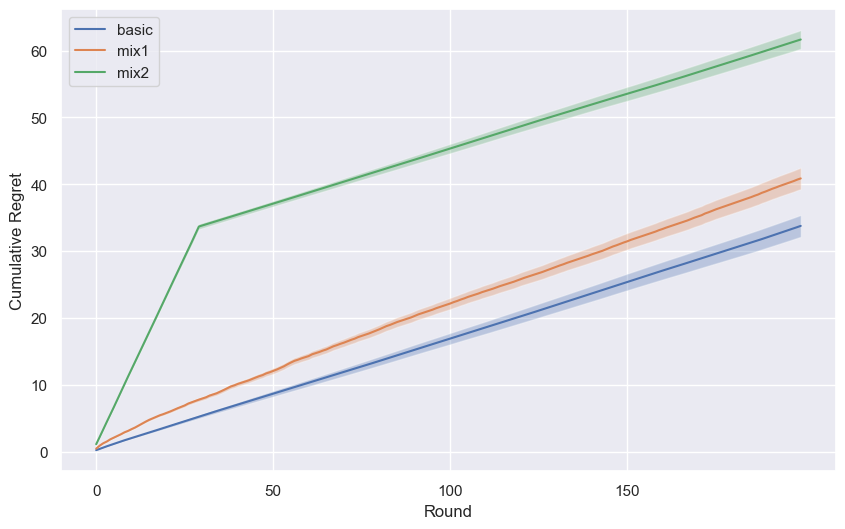

In [26]:
# plot mix strategy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# load data
df_regrets = pd.read_csv('data/Qtransformer_random_regrets_0706_2.csv')

df_regrets_mix1 = pd.read_csv('data/Qtransformer_random_regrets_0706_2_mix1.csv')
df_regrets_mix2 = pd.read_csv('data/Qtransformer_random_regrets_0706_2_mix2.csv')
# df_regrets = pd.read_csv('data/Qtransformer_ucb_regrets.csv')
# print(df_regrets.shape)
sns.set()
plt.figure(figsize=(10, 6))
plt.plot(df_regrets.mean(), label='basic')
plt.fill_between(df_regrets.columns, df_regrets.mean() - df_regrets.std()/np.sqrt(num_trajectories), df_regrets.mean() + df_regrets.std()/np.sqrt(num_trajectories), alpha=0.3)
plt.plot(df_regrets_mix1.mean(), label='mix1')
plt.fill_between(df_regrets_mix1.columns, df_regrets_mix1.mean() - df_regrets_mix1.std()/np.sqrt(num_trajectories), df_regrets_mix1.mean() + df_regrets_mix1.std()/np.sqrt(num_trajectories), alpha=0.3)
plt.plot(df_regrets_mix2.mean(), label='mix2')
plt.fill_between(df_regrets_mix2.columns, df_regrets_mix2.mean() - df_regrets_mix2.std()/np.sqrt(num_trajectories), df_regrets_mix2.mean() + df_regrets_mix2.std()/np.sqrt(num_trajectories), alpha=0.3)

plt.legend()

plt.xlabel('Round')
# ever 50 rounds set a x-tick
plt.xticks(np.arange(0, T, 50))
plt.ylabel('Cumulative Regret')

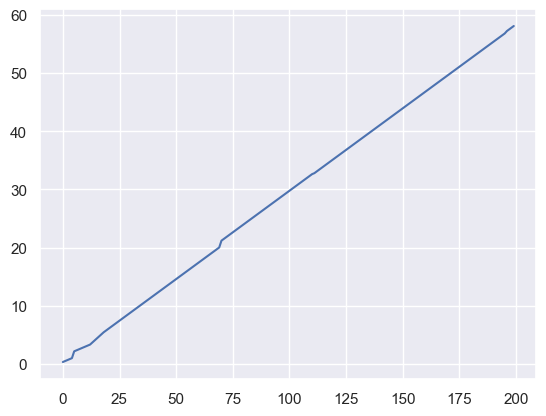

In [21]:
# eval the transformer model
from icrl import *
from model import *
config = {
        'horizon': 200,
        'dim':5,
        'act_num':10,
        'state_dim': 50,
        'action_dim': 10,
        'n_layer': 8,
        'n_embd': 32,
        'n_head': 4,
        'shuffle': True,
        'dropout': 0,
        'test': True,
        'act_type': 'relu',
        'pred_q': True,
    }
num_actions = 10
context_dim = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
T = 200


model = Transformer(config)
model.load_state_dict(torch.load('model/Qtransformer_model_ucb.pth'))
model.to(device)
model.eval()  # 确保模型在评估模式

env = Environment(num_actions, context_dim)
best_action_index = env.get_best_action_index()  # Best action doesn't change in this setup
best_action_reward = np.dot(env.action_set[best_action_index], env.w_star)
# evaluate the model
total_regrets = np.zeros(T)
total_regret = 0
action_set = env.get_action_set()
action_set = torch.tensor(action_set, dtype=torch.float32).to(device).reshape(-1)
action_indices = []
rewards = []

initilize_prob = 0.2

for t in range(1, T+1):
    if t == 1:
        context_actions = torch.empty(0, num_actions).to(device).unsqueeze(0) # batch_size, 0, num_actions
        context_rewards = torch.empty(0, 1).to(device).unsqueeze(0) # batch_size, 0, 1
        x = {
            'action_set': action_set.unsqueeze(0),
            'context_actions': context_actions,
            'context_rewards': context_rewards
        }
    else:
        x = {
            'action_set': action_set.unsqueeze(0),
            'context_actions': context_actions,
            'context_rewards': context_rewards
        }
        # action_indices = model(x)

    random_number = np.random.rand() # 0-1
    if random_number < initilize_prob/np.sqrt(t):
        # dimention [batchsize, 1]
        action_indices = torch.randint(0, num_actions, (1, 1)).to(device)
    else:

        last_timestep_outputs = model(x)
        # last_timestep_outputs = model_outputs[:, -1, :]

        # 找到最后一个时间步中每个动作得分最高的索引
        # action_indices = last_timestep_outputs.argmax(dim=1)
        # 找到最后一个时间步，用softmax算出每个动作的概率，并按照概率随机选择动作
        # action_indices = torch.multinomial(torch.softmax(last_timestep_outputs, dim=1), 1)
        action_indices = last_timestep_outputs.argmax(dim=-1).unsqueeze(1) # batchsize, 1 
        # print(action_indices.shape)
    rewards_ = env.step(action_indices[0].item())[0]
    actions_ = env.step(action_indices[0].item())[1]
    # 转化成一个one-hot向量
    actions_one_hot = torch.zeros(1, 1, num_actions).to(device) # batch_size, 1, num_actions

    actions_one_hot.scatter_(2, action_indices.unsqueeze(0), 1) # batch_size, num_actions

    reward_tensor = torch.tensor(rewards_, dtype=torch.float32).to(device).unsqueeze(0).unsqueeze(0).unsqueeze(0) # batch_size, 1, 1
    # print(reward_tensor.shape)
    context_actions = torch.cat((context_actions, actions_one_hot), dim=1)
    context_rewards = torch.cat((context_rewards, reward_tensor), dim=1)

    # Calculate regret for this round and add to total
    expected_reward = np.dot(env.action_set[action_indices[0].item()], env.w_star)
    # print(expected_reward)
    round_regret = best_action_reward - expected_reward
    total_regret += round_regret
    total_regrets[t-1] = total_regret
# 画出total regret，横轴是时间，纵轴是累计遗憾
plt.plot(total_regrets)

# Random choose + Transformer

In [12]:
import tqdm 
config = {
        'horizon': 200,
        'dim':5,
        'act_num':10,
        'state_dim': 50,
        'action_dim': 10,
        'n_layer': 8,
        'n_embd': 32,
        'n_head': 4,
        'shuffle': True,
        'dropout': 0,
        'test': True,
        'act_type': 'relu',
        'pred_q': False,
    }
num_actions = 10
context_dim = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
T = 200


model = Transformer(config)
model.load_state_dict(torch.load('model/transformer_model_random.pth'))
model.to(device)
model.eval()  # 确保模型在评估模式
# evaluate the model
num_trajectories = 1000

batchsize = 32

trajectories = [] # Store all trajectories
# In this setting, s_t = \mathbb{A} = action_set!
all_regrets = np.zeros((num_trajectories, T))

# use tqdm to show progress bar
# for i in tqdm.tqdm(range(num_trajectories)):
for i in tqdm.tqdm(range(num_trajectories//batchsize)):

    envs = [Environment(num_actions, context_dim) for _ in range(batchsize)]
    total_regret = np.zeros(batchsize)
    # regrets = np.zeros((batchsize, T))
    regrets = [[] for _ in range(batchsize)]

    best_action_indexs = [env.get_best_action_index() for env in envs]  # Best action doesn't change in this setup
    best_action_rewards = [np.dot(env.action_set[best_action_index], env.w_star) for env, best_action_index in zip(envs, best_action_indexs)]
    states, actions, rewards, action_indexs = [[] for _ in range(batchsize)], [[] for _ in range(batchsize)], [[] for _ in range(batchsize)], [[] for _ in range(batchsize)]
    action_sets = [torch.tensor(env.get_action_set(), dtype=torch.float32).to(device).reshape(-1) for env in envs]
    action_sets = torch.stack(action_sets).reshape(batchsize, -1) # [batchsize, num_actions*context_dim]


    # embeddings = []
    for t in range(1, T+1):
        if t == 1:
            context_actions = torch.empty((batchsize, 0, num_actions), dtype=torch.float32).to(device)
            context_rewards = torch.empty((batchsize, 0, 1), dtype=torch.float32).to(device)
            x = {
                'action_set': action_sets,
                'context_actions': context_actions,
                'context_rewards': context_rewards
            }
        else:
            x = {
                'action_set': action_sets,
                'context_actions': context_actions,
                'context_rewards': context_rewards
            }
        last_timestep_outputs = model(x) 
        # last_timestep_outputs shape: [batchsize, num_actions]
        action_indices = torch.multinomial(F.softmax(last_timestep_outputs, dim=-1), 1) #dimension [batchsize, 1]


        rewards_ = [env.step(action_index)[0] for env, action_index in zip(envs, action_indices)]
        actions_ = [env.step(action_index)[1] for env, action_index in zip(envs, action_indices)]
        # print(len(actions_))
        # find action
        actions_one_hot = torch.zeros(batchsize, 1, num_actions).to(device)
        actions_one_hot.scatter_(2, action_indices.unsqueeze(1), 1)

        reward_tensor = torch.tensor(rewards_, dtype=torch.float32).to(device).reshape(batchsize, 1, 1)
        
        context_actions = torch.cat([context_actions, actions_one_hot], dim=1)
        context_rewards = torch.cat([context_rewards, reward_tensor], dim=1)

        
        expected_rewards = [np.dot(env.action_set[action_index], env.w_star) for env, action_index in zip(envs, action_indices)]
        
        # round_regret = best_action_reward - expected_reward
        round_regrets = [best_action_reward - expected_reward for best_action_reward, expected_reward in zip(best_action_rewards, expected_rewards)]
        # print(round_regret)
        # total_regret += round_regret
        total_regret += round_regrets
        for j in range(batchsize):
            regrets[j].append(total_regret[j])
            states[j].append(envs[j].get_action_set())
            actions[j].append(actions_[j])
            rewards[j].append(rewards_[j])
            action_indexs[j].append(action_indices[j].item())

    # all_regrets[i] = regrets # Store regrets for this trajectory
    all_regrets[i*batchsize:(i+1)*batchsize] = regrets
    trajectories.append((states, actions, rewards, action_indexs)) # Store trajectory

100%|██████████| 31/31 [02:23<00:00,  4.62s/it]


In [13]:
# save the regrets
import pandas as pd
df_regrets = pd.DataFrame(all_regrets)
df_regrets.to_csv('data/transformer_random_regrets.csv', index=False)

# Integration

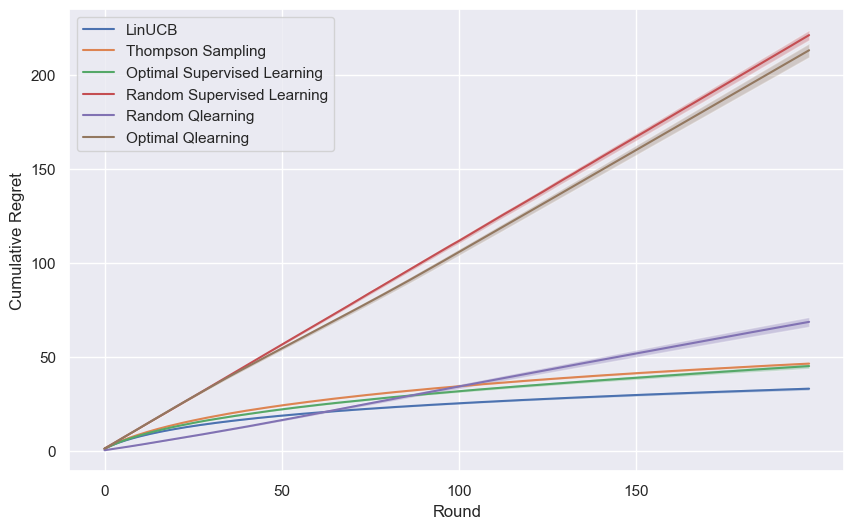

In [7]:
#linucb, thompson, transformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load data
df_linucb = pd.read_csv('data/linucb_regrets.csv')
df_thompson = pd.read_csv('data/Thompson_regrets.csv')
df_transformer = pd.read_csv('data/transformer_regrets.csv')
df_transformer_random = pd.read_csv('data/transformer_random_regrets.csv')
df_Qtransformer = pd.read_csv('data/Qtransformer_random_regrets.csv')
df_Qtransformer_ucb = pd.read_csv('data/Qtransformer_ucb_regrets.csv')

# plot the average regret with confidence interval
sns.set()
plt.figure(figsize=(10, 6))
plt.plot(df_linucb.mean(), label='LinUCB')
plt.fill_between(df_linucb.columns, df_linucb.mean() - df_linucb.std()/np.sqrt(num_trajectories), df_linucb.mean() + df_linucb.std()/np.sqrt(num_trajectories), alpha=0.3)

plt.plot(df_thompson.mean(), label='Thompson Sampling')
plt.fill_between(df_thompson.columns, df_thompson.mean() - df_thompson.std()/np.sqrt(num_trajectories), df_thompson.mean() + df_thompson.std()/np.sqrt(num_trajectories), alpha=0.3)

plt.plot(df_transformer.mean(), label='Optimal Supervised Learning')
plt.fill_between(df_transformer.columns, df_transformer.mean() - df_transformer.std()/np.sqrt(num_trajectories), df_transformer.mean() + df_transformer.std()/np.sqrt(num_trajectories), alpha=0.3)

plt.plot(df_transformer_random.mean(), label='Random Supervised Learning')
plt.fill_between(df_transformer_random.columns, df_transformer_random.mean() - df_transformer_random.std()/np.sqrt(num_trajectories), df_transformer_random.mean() + df_transformer_random.std()/np.sqrt(num_trajectories), alpha=0.3)

plt.plot(df_Qtransformer.mean(), label='Random Qlearning')
plt.fill_between(df_Qtransformer.columns, df_Qtransformer.mean() - df_Qtransformer.std()/np.sqrt(num_trajectories), df_Qtransformer.mean() + df_Qtransformer.std()/np.sqrt(num_trajectories), alpha=0.3)

plt.plot(df_Qtransformer_ucb.mean(), label='Optimal Qlearning')
plt.fill_between(df_Qtransformer_ucb.columns, df_Qtransformer_ucb.mean() - df_Qtransformer_ucb.std()/np.sqrt(num_trajectories), df_Qtransformer_ucb.mean() + df_Qtransformer_ucb.std()/np.sqrt(num_trajectories), alpha=0.3)

plt.xlabel('Round')
# ever 50 rounds set a x-tick
plt.xticks(np.arange(0, T, 50))
plt.ylabel('Cumulative Regret')
plt.legend()
plt.savefig('all_regret.png')